# Empirical Application 1 Financial Econometrics

*By Daniel Deutsch, José Lucas Barretto, and Stéphane Roblet*

In [20]:
import itertools
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.tsa.stattools as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

In [21]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 4),
    'axes.prop_cycle': plt.cycler(color=["#4C72B0", "#C44E52", "#55A868", "#8172B2", "#CCB974", "#64B5CD"]),
    'axes.facecolor': "#EAEAF2"
})

# US Governament Bond Yields

## Load the Data

Notice that here we don't apply the log-transform in our data since it is already given in percentage.

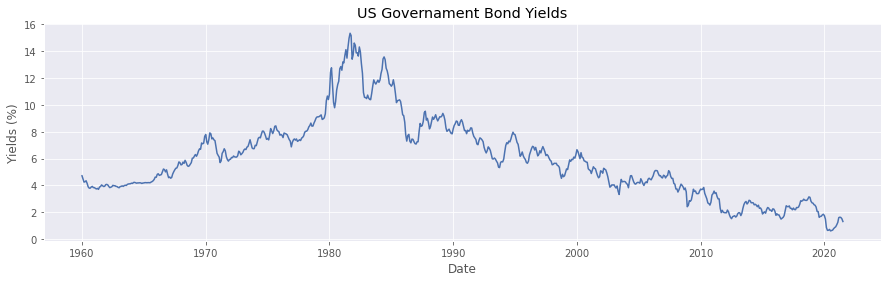

In [22]:
# Loads data and drops non available values
df_govbonds = pd.read_csv("datasets/US_govbonds_yields.csv", names=['date', 'value'], parse_dates=['date'], skiprows=[0], na_values='.')
df_govbonds.dropna(inplace=True)

# Plots the time series
plt.plot(df_govbonds['date'], df_govbonds['value'])
plt.title("US Governament Bond Yields")
plt.xlabel("Date")
plt.ylabel("Yields (%)")
plt.show()

## Augmented Dickey-Fuller Test

The Augmented Dickey-Fuller test is a unit root test that checks for stationarity. It considers the following hypotesis:

$
\begin{aligned}
    H_0: & \quad \text{there is a unit root (the series contains a stochastic trend and is non-stationary)} \\
    H_1: & \quad \text{there isn't a unit root (the series doesn't contain a stochastic trend and is stationary)}
\end{aligned}
$

Once the Augmented Dickey-Fuller Test is performed and we have obtained our results, we should consider the following to take our conclusions:

- If the p-value is lower than 0.05, than we must reject the null hypotesys (and, consequently, accept the alternativel one).
- If the p-value is slightly above 0.05, then the critical values should be used to judge whether to reject the null hypotesis.

<br>

First, we are going to implement the augmented Dickey-Fuller Test to the most general regression:

$
\begin{aligned}
    \Delta X_t = b_0 + b_1 t + \rho X_{t-1} + \sum^{p-1}_{j=1} \varphi_j \Delta_{t-j} + \varepsilon_t 
\end{aligned}
$

In this case, the hypotesis can be written as:

$
\begin{aligned}
    H_0: & \quad \rho = 0 \\
    H_1: & \quad \rho < 0
\end{aligned}
$

In [23]:
# Obtains the ADF results for the general regression
adf_res = sm.adfuller(
    df_govbonds['value'], 
    regression='ct',
    maxlag=12, 
    autolag='AIC', 
    regresults=True
)

# Show test results
print(f"T-statistic: {adf_res[0]}")
print(f"P-value: {adf_res[1]}")
print(f"Used lag: {adf_res[3].usedlag}")

T-statistic: -2.159620149647254
P-value: 0.5125920716409773
Used lag: 12


From the results printed above we can conclude that **the null hypotesis shouldn't be rejected**, i.e., there isn't a unit root in the time series (it is non-stationary), since the p-value is way higher than 0.05. One could reach the same conclusion by observing the value of the T-statistic (since it's absolute value is lower than the absolute value of -3.45).

Once we didn't reject the null hypotesis, we should test wether the coefficient $b_1$ is significant or not.

In [24]:
print(adf_res[3].resols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     10.69
Date:                Sat, 18 Sep 2021   Prob (F-statistic):           2.90e-22
Time:                        16:30:51   Log-Likelihood:                -27.423
No. Observations:                 726   AIC:                             84.85
Df Residuals:                     711   BIC:                             153.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0081      0.004     -2.160      0.0

In the print above, the coefficient $b_1$ is represented by the variable x14 (which can only be seen once you click at "*show more (open the raw output data in a text editor) ...*"). We observe that its T-statistic is -2.141. Since the absolute value of its T-statistic is inferior than the T-statistic of 2.78 at the 5% confidence level, we conclude that **the trend coefficient $b_1$ is not statistically significant**.

Now, since we concluded that $b_1$ isn't statistically significant, we shall perform the ADF test again, but this time considering a restricted regression, as following:

$
\begin{aligned}
    \Delta X_t = b_0 + \rho X_{t-1} + \sum^{p-1}_{j=1} \varphi_j \Delta_{t-j} + \varepsilon_t 
\end{aligned}
$

Again, our hypotesis can be written as:

$
\begin{aligned}
    H_0: & \quad \rho = 0 \\
    H_1: & \quad \rho < 0
\end{aligned}
$

In [25]:
# Obtains the ADF results for the restricted regression
adf_res = sm.adfuller(
    df_govbonds['value'], 
    regression='c',
    maxlag=12, 
    autolag='AIC', 
    regresults=True
)

# Show test results
print(f"T-statistic: {adf_res[0]}")
print(f"P-value: {adf_res[1]}")
print(f"Used lag: {adf_res[3].usedlag}")

T-statistic: -1.294841876108271
P-value: 0.6315288451340434
Used lag: 12


Once more, from the results printed above, we can conclude that **the null hypotesis shouldn't be rejected**, i.e., there isn't a unit root in the time series (it is non-stationary), since the p-value is way higher than 0.05. The same conclusion could be reached by observing the value of the T-statistic (since it's absolute value is lower than the absolute value of -2.89).

Once we didn't reject the null hypotesis, we should test wether the coefficient $b_0$ is significant or not.

In [26]:
print(adf_res[3].resols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     11.10
Date:                Sat, 18 Sep 2021   Prob (F-statistic):           6.93e-22
Time:                        16:30:52   Log-Likelihood:                -29.756
No. Observations:                 726   AIC:                             87.51
Df Residuals:                     712   BIC:                             151.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0043      0.003     -1.295      0.1

In the print above, the coefficient $b_0$ is represented by the variable const (which can only be seen once you click at "*show more (open the raw output data in a text editor) ...*"). We observe that its T-statistic is 1.053. Since the absolute value of its T-statistic is inferior than the T-statistic of 2.54 at the 5% confidence level, we conclude that **the drift coefficient $b_0$ is not statistically significant**.

Now, since we concluded that $b_0$ isn't statistically significant, we shall perform the ADF test again, but this time considering an even more restricted regression, as following:

$
\begin{aligned}
    \Delta X_t = \rho X_{t-1} + \sum^{p-1}_{j=1} \varphi_j \Delta_{t-j} + \varepsilon_t 
\end{aligned}
$

Again, our hypotesis can be written as:

$
\begin{aligned}
    H_0: & \quad \rho = 0 \\
    H_1: & \quad \rho < 0
\end{aligned}
$

In [27]:
# Obtains the ADF results for the restricted regression
adf_res = sm.adfuller(
    df_govbonds['value'], 
    regression='nc',
    maxlag=12, 
    autolag='AIC', 
    regresults=True
)

# Show test results
print(f"T-statistic: {adf_res[0]}")
print(f"P-value: {adf_res[1]}")
print(f"Used lag: {adf_res[3].usedlag}")

T-statistic: -0.7996081095853742
P-value: 0.3706833546535423
Used lag: 12


Once more, from the results printed above, we can conclude that **the null hypotesis shouldn't be rejected**, i.e., there isn't a unit root in the time series (it is non-stationary), since the p-value is way higher than 0.05. The same conclusion could be reached by observing the value of the T-statistic (since it's absolute value is lower than the absolute value of -1.95).

Once we didn't reject the null hypotesis, we finally conclude that **the series is non-stationary without constant**. We can verify this result by running the Augmented Dickey-Fuller test on the first difference of the series: 

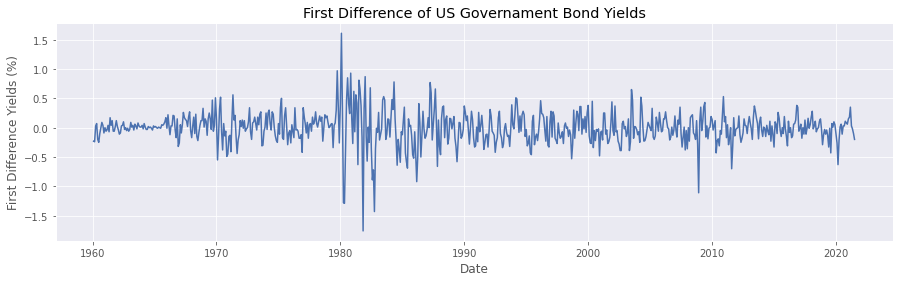

In [28]:
# Obtains the first difference of the time series
df_govbonds['diff'] = df_govbonds['value'].diff()

# Plots the first difference time series
plt.plot(df_govbonds['date'], df_govbonds['diff'])
plt.title("First Difference of US Governament Bond Yields")
plt.xlabel("Date")
plt.ylabel("First Difference Yields (%)")
plt.show()

In [29]:
# Obtains the ADF results for the restricted regression
adf_res = sm.adfuller(
    df_govbonds['diff'].dropna(), 
    regression='ct',
    maxlag=12, 
    autolag='AIC', 
    regresults=True
)

# Show test results
print(f"T-statistic: {adf_res[0]}")
print(f"P-value: {adf_res[1]}")
print(f"Used lag: {adf_res[3].usedlag}")

T-statistic: -7.363656510594449
P-value: 2.0960706199430693e-09
Used lag: 11


From the results printed above, we can conclude that **the null hypotesis should be rejected**, i.e., there is a unit root in the time series (it is stationary), since the p-value is way lower than 0.05. This means that US Governament Bond Yields are I(1).

<br>

## Decomposition and Analysis of Drift, Trend, and Seasonality for the First Difference Series

Now, we shall decompose the first difference series into trend, seasonality, and residues (cyclical component). We will assume that the series follow an annual period, and thus, we consider a period of 253 days (average number of trading days per year).

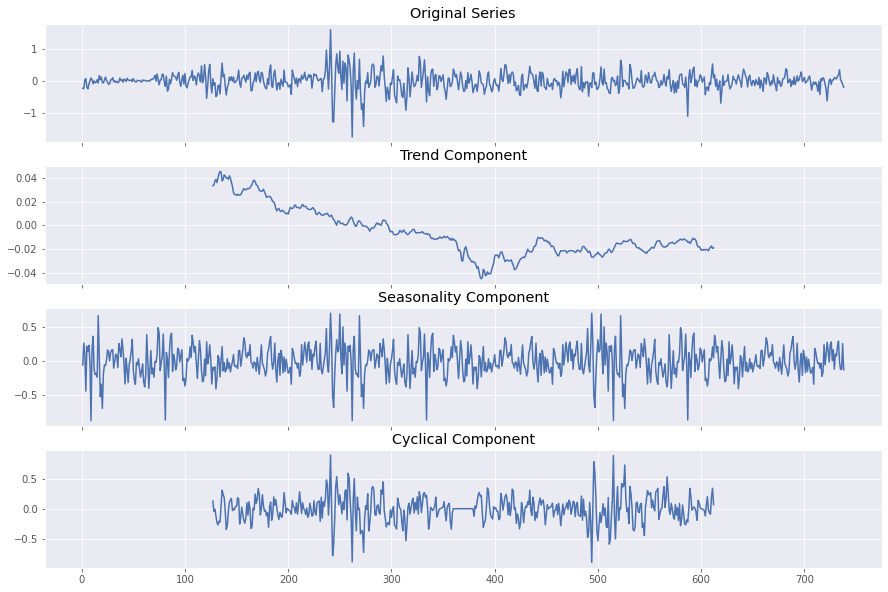

In [30]:
# Decomposes the time series
decomposition = seasonal_decompose(df_govbonds['diff'].dropna(), model='additive', period=253)

# Plot
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(15, 10))
df_govbonds['diff'].plot(ax=axs[0])
decomposition.trend.plot(ax=axs[1])
decomposition.seasonal.plot(ax=axs[2])
decomposition.resid.plot(ax=axs[3])
axs[0].set_title("Original Series")
axs[1].set_title("Trend Component")
axs[2].set_title("Seasonality Component")
axs[3].set_title("Cyclical Component")
plt.show()

### Deterministic Trend

In [31]:
model = OLS(df_govbonds['diff'].dropna(), decomposition.trend, missing='drop')
print(model.fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                   diff   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              1.728
Date:                Sat, 18 Sep 2021   Prob (F-statistic):                       0.189
Time:                        16:30:53   Log-Likelihood:                         -130.86
No. Observations:                 486   AIC:                                      263.7
Df Residuals:                     485   BIC:                                      267.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

From the print above we can see that the trend component isn't statistically significant at the level 5%. This result indicates that the series doesn't have a deterministic trend when considering an annual period.

### Seasonality

In [32]:
model = OLS(df_govbonds['diff'].dropna(), decomposition.seasonal, missing='drop')
print(model.fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                   diff   R-squared (uncentered):                   0.317
Model:                            OLS   Adj. R-squared (uncentered):              0.316
Method:                 Least Squares   F-statistic:                              341.6
Date:                Sat, 18 Sep 2021   Prob (F-statistic):                    5.79e-63
Time:                        16:30:53   Log-Likelihood:                          46.544
No. Observations:                 738   AIC:                                     -91.09
Df Residuals:                     737   BIC:                                     -86.48
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

From the print above we can see that the seasonal component is statistically significant at the level 5%. This result indicates that the series has seasonality when considering an annual period.

We can also verify this by using dummy variables for each month and verifying their statistical significance.

In [33]:
# Creates dummy vars columns for week of the year
df_govbonds['period'] = df_govbonds['date'].dt.weekofyear

# Create a column for each dummy var
for period in df_govbonds['period'].unique():
    df_govbonds[f'week_{period}'] = 1*(df_govbonds['period'] == period)

# Include all dummy vars except one
X = df_govbonds[[f'week_{period}' for period in sorted(df_govbonds['period'].unique())[:-1]]]

# Run regression
model = OLS(df_govbonds['diff'], X, missing='drop')
print(model.fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                   diff   R-squared (uncentered):                   0.022
Model:                            OLS   Adj. R-squared (uncentered):             -0.009
Method:                 Least Squares   F-statistic:                             0.7028
Date:                Sat, 18 Sep 2021   Prob (F-statistic):                       0.846
Time:                        16:30:53   Log-Likelihood:                         -85.748
No. Observations:                 738   AIC:                                      217.5
Df Residuals:                     715   BIC:                                      323.4
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The results indicate that some weeks of the year have statistically significant impacts on the value of the first difference series. This supports the previous finding that the series has a significant seasonal component.

## Stationary ARMA Model

The goal here is to estimate the cyclical component through a stationary ARMA model. Firstly, we can plot the Autocorrelation and the Partial Autocorrelation of the time series to have an idea of the parameters of the model.

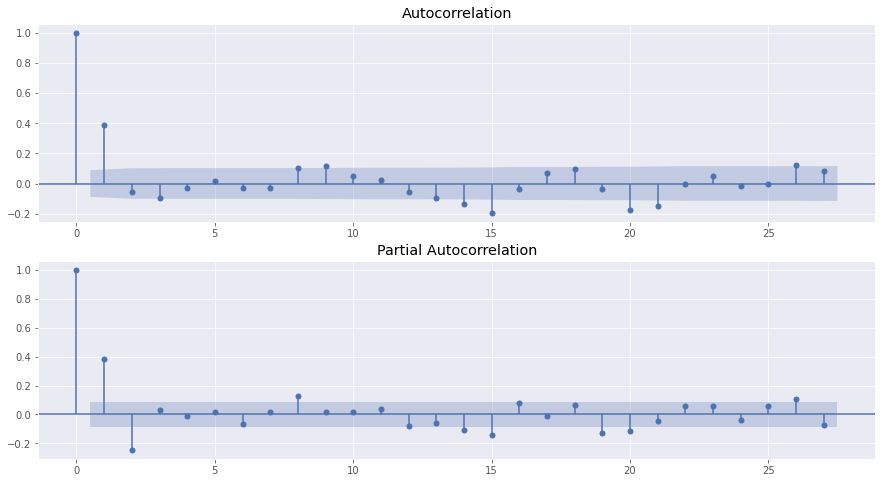

In [34]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8))
plot_acf(decomposition.resid.dropna(), ax=axs[0])
plot_pacf(decomposition.resid.dropna(), ax=axs[1])
plt.show()

To obtain the best parameters for the ARMA model we run a cross-validation using the AIC score (select the model with the lowest AIC).

In [36]:
best_model = None
for p, q in itertools.product(range(10), range(10)):

    print(f"\rCurrent {p=}, {q=}", end="")

    model = ARIMA(decomposition.resid.dropna(), order=(p, 0, q))
    model_fit = model.fit()

    if p == 0 and q == 0:
        best_model = model_fit

    if model_fit.aic < best_model.aic:
        best_model = model_fit

print(best_model.summary())

Current p=9, q=9                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  486
Model:                 ARIMA(4, 0, 9)   Log Likelihood                 125.189
Date:                Sat, 18 Sep 2021   AIC                           -220.378
Time:                        16:37:26   BIC                           -157.585
Sample:                             0   HQIC                          -195.708
                                - 486                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0072      0.012     -0.587      0.557      -0.031       0.017
ar.L1          0.0366      0.094      0.388      0.698      -0.148       0.221
ar.L2          0.3762      0.078    